# Описание проекта

**Контекст** - крупный интернет-магазин. Подготовлен список гипотез для увеличения выручки. 

**Цель** - приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.


### План
1. [Загрузить и подготовить данные к анализу](#step1)
    - [Загрузка и предварительный взгляд](#step1.1)
    - [Подготовка данных](#step1.2)
    
    
2. [Приоритизировать гипотезы](#step2)
    - [Применение ICE](#step2.1)
    - [Применение RICE](#step2.2)
    - [Выводы](#step2.3)
 

3. [Проанализировать A/B-тест](#step3)
    - [Построение графиков](#step3.1)
    - [Поиск аномалий](#step3.2)
    - [Посчет статистической значимости](#step3.3)
    - [Выводы](#step3.4)


4. [Сделать общие выводы](#step4)

# Шаг 1. Загрузка и подготовка данных <a id="step1"></a> 

## Загрузка и предварительный взгляд <a id="step1.1"></a> 

In [1]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats as stats
import math as mth
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('Set2')

In [8]:
filenames = ['/datasets/hypothesis.csv', '/datasets/orders.csv', '/datasets/visitors.csv']
hypotheses, orders, visitors = [pd.read_csv(file) for file in filenames]
df_names = [hypotheses, orders, visitors]
for i in range(len(filenames)):
    filenames[i]
    pd.set_option('display.max_colwidth', 150)
    df_names[i].head(10)
    df_names[i].info()

'/datasets/hypothesis.csv'

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


'/datasets/orders.csv'

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


'/datasets/visitors.csv'

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Сравним распределение дат в таблицах orders и visitors.

In [9]:
orders.duplicated().sum()
visitors.duplicated().sum()

0

0

In [10]:
orders['date'].describe()
visitors['date'].describe()

count           1197
unique            31
top       2019-08-05
freq              48
Name: date, dtype: object

count             62
unique            31
top       2019-08-30
freq               2
Name: date, dtype: object

Мы загрузили три таблицы hypotheses, orders и visitors. На первый взгляд данные чистые, дубликатов нет.  A/B-тест длился 31 день, диапазон дат совпадает в таблицах orders и visitors. 

Необходимо перевести даты в нужный формат. Также для удобства приведем названия столбцов hypotheses к нижнему регистру и поменяем названия столбцов в orders. Кроме того, надо проверить, как пользователи распределены по группам и нет ли тех, кто попал в обе группы. Проверка на аномалии будет сделана позже, в разделе анализа A/B-теста.

## Подготовка данных <a id="step1.2"></a> 

## Таблица hypotheses

In [11]:
hypotheses.columns = hypotheses.columns.str.lower()
hypotheses.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Выведем полный текст гипотез, чтобы внимательно с ними ознакомиться.

In [12]:
hypotheses['hypothesis'].values

array(['Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
       'Запустить собственную службу доставки, что сократит срок доставки заказов',
       'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
       'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
       'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
       'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
       'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию',
       'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
       'Запустить акцию, дающую скидку на товар в день рождения'],
      dtype=object)

Уберем небольшую описку.

In [13]:
hypotheses['hypothesis'] = hypotheses['hypothesis'].str.replace('структура', 'структуру')
hypotheses['hypothesis'].values[3]

'Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар'

Таблица готова.

## Таблица orders

Заменим тип дат и названия столбцов.

In [14]:
orders['date'] = pd.to_datetime(orders['date'])
orders = orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'})
orders['transaction_id'] = orders['transaction_id'].astype('object')
orders['visitor_id'] = orders['visitor_id'].astype('object')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null object
visitor_id        1197 non-null object
date              1197 non-null datetime64[ns]
revenue           1197 non-null int64
group             1197 non-null object
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 46.9+ KB


Посмотрим количество уникальных пользователей и сборную таблицу по группам.

In [15]:
print('Количество уникальных пользователей, сделавших заказ: ', orders.visitor_id.nunique())

by_groups = orders.groupby('group').agg({'transaction_id':'count', 'visitor_id':'nunique', 'date':'nunique', 'revenue':'sum'})
by_groups
print('Суммарно пользователей по группам: ', by_groups.visitor_id.sum())

Количество уникальных пользователей, сделавших заказ:  1031


,transaction_id,visitor_id,date,revenue
group,,,,
A,557,503,31,4084803
B,640,586,31,5907760


Суммарно пользователей по группам:  1089


Всего 1031 уникальных покупателей. В группе B немногим больше пользователей. 

Кроме того, мы получили расхождение между количеством уникальных пользователей и суммарным количеством уникальных пользователей по группам, значит, есть пользователи, которые попали в обе группы. Исследуем их подробнее. Выделим id посетителей, которые попали в обе группы и сделаем по ним срез.

In [16]:
odd_visitors_id = orders.groupby('visitor_id').agg({'group':'nunique'}).query('group > 1').index
odd_visitors_id
print('Количество пользователей, которые попали в обе группы:', len(odd_visitors_id))

Int64Index([   8300375,  199603092,  232979603,  237748145,  276558944,
             351125977,  393266494,  457167155,  471551937,  477780734,
             818047933,  963407295, 1230306981, 1294878855, 1316129916,
            1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
            1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
            2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
            2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
            2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
            3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
            3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
            3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
            4186807279, 4256040402, 4266935830],
           dtype='int64', name='visitor_id')

Количество пользователей, которые попали в обе группы: 58


58 пользователей попали в обе группы. Посмотрим, какой процент заказов на них приходится. 

In [17]:
odd_users_orders = orders.query('visitor_id in @odd_visitors_id').copy()
odd_users_orders.sort_values(by=['visitor_id', 'date']).head(15)
print('Количество заказов:', len(odd_users_orders))
print('Процент от общего числа заказов: {:.2%}'.format(len(odd_users_orders)/len(orders)))
print('Процент дохода от общего дохода: {:.2%}'.format(odd_users_orders.revenue.sum()/orders.revenue.sum()))
print('Соотношение по группам:')
odd_users_orders.group.value_counts(normalize=True)

,transaction_id,visitor_id,date,revenue,group
71,3679129301,8300375,2019-08-01,10510,B
703,4293855558,8300375,2019-08-07,1790,A
246,437656952,199603092,2019-08-02,3488,B
1102,1941707234,199603092,2019-08-12,6438,A
26,2223239646,199603092,2019-08-15,3488,A
134,62794304,199603092,2019-08-22,6976,A
823,2971973105,199603092,2019-08-27,2790,A
1009,2670069237,232979603,2019-08-31,2640,B
1013,83566152,232979603,2019-08-31,60,A
1097,3357467820,237748145,2019-08-12,340,A


Количество заказов: 181
Процент от общего числа заказов: 15.12%
Процент дохода от общего дохода: 15.60%
Соотношение по группам:


B    0.508287
A    0.491713
Name: group, dtype: float64

Итак, 15.12% заказов и 15.6% дохода приходится на пользователей, которые попали в обе группы. Причем, есть пользователи, которые были два раза и оба раза попали в разные группы, а есть те, кто был несколько раз и только один из них попал в другую группу. Это серьезное упущение и такую информацию необходимо было бы передать тем, кто запускал A/B-тест, чтобы они нашли, почему так получилось, и отрегулировали это для следующих тестов. 

Для данного анализа необходимо удалить данных пользователей и их заказы, чтобы избежать искажения результатов теста. 

In [18]:
orders = orders.query('visitor_id not in @odd_visitors_id')
orders.info()
by_groups_2 = orders.groupby('group').agg({'transaction_id':'count', 'visitor_id':'nunique', 'date':'nunique', 'revenue':'sum'})
by_groups_2

print('Пользователи разных групп не пересекаются:')
orders.visitor_id.nunique() == by_groups_2.visitor_id.sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1016 non-null object
visitor_id        1016 non-null object
date              1016 non-null datetime64[ns]
revenue           1016 non-null int64
group             1016 non-null object
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 47.6+ KB


,transaction_id,visitor_id,date,revenue
group,,,,
A,468,445,31,3364656
B,548,528,31,5068972


Пользователи разных групп не пересекаются:


True

Таблица orders готова к анализу.

## Таблица visitors

Приведем дату к нужному формату.

In [19]:
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверим соотношение посетителей по группам.

In [20]:
visitors.groupby('group').visitors.sum()/visitors.visitors.sum()

group
A    0.49761
B    0.50239
Name: visitors, dtype: float64

Поскольку мы удалили часть заказов, теперь необходимо также удалить этих пользователей из посетителей. Соберем таблицу, где посчитаем, сколько уникальных пользователей из тех, что мы удалили, приходится на каждую дату по группам.

In [21]:
odd_users_sessions = odd_users_orders.groupby(['date', 'group']).agg({'visitor_id':'nunique'}).reset_index()
odd_users_sessions = odd_users_sessions.rename(columns={'visitor_id':'odd_visitors'})
odd_users_sessions.head(10)
len(odd_users_sessions)

,date,group,odd_visitors
0,2019-08-01,A,1
1,2019-08-01,B,3
2,2019-08-02,A,1
3,2019-08-02,B,1
4,2019-08-03,B,2
5,2019-08-04,A,4
6,2019-08-04,B,3
7,2019-08-05,A,3
8,2019-08-05,B,2
9,2019-08-06,A,3


56

Посетители, которых надо удалить, приходятся не на все дни. Это важно для правильного соединения таблиц. Соединим таблицы  visitors и odd_users_sessions и уменьшим общее число посетителей. Затем уберем ненужный столбец.

In [22]:
visitors = visitors.merge(odd_users_sessions, on=['date', 'group'], how='left')
visitors = visitors.fillna(0)
visitors['visitors'] = visitors.visitors - visitors.odd_visitors
visitors['visitors'] = visitors['visitors'].astype('int')
visitors = visitors.drop(columns=['odd_visitors'])
visitors

,date,group,visitors
0,2019-08-01,A,718
1,2019-08-02,A,618
2,2019-08-03,A,507
3,2019-08-04,A,713
4,2019-08-05,A,753
...,...,...,...
57,2019-08-27,B,715
58,2019-08-28,B,649
59,2019-08-29,B,526
60,2019-08-30,B,487


Еще раз проверим соотношение

In [23]:
visitors.groupby('group').visitors.sum()/visitors.visitors.sum()

group
A    0.497572
B    0.502428
Name: visitors, dtype: float64

Соотношение практически не поменялось. Таблица готова. 

# Шаг 2. Приоритизация гипотез <a id="step2"></a> 

## Применение ICE <a id="step2.1"></a> 

Применим фреймфорк ICE.

In [24]:
hypotheses['ice'] = (hypotheses.impact * hypotheses.confidence) / hypotheses.efforts

pd.options.display.max_colwidth = 150
hypotheses[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективными гипотезами получились:
- "Запустить акцию, дающую скидку на товар в день рождения" (8)
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" (0)
- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" (7)

## Применение RICE <a id="step2.2"></a> 

Применим фреймфорк RICE.

In [25]:
hypotheses['rice'] = (hypotheses.reach * hypotheses.impact * hypotheses.confidence) / hypotheses.efforts

pd.options.display.max_colwidth = 150
hypotheses[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структуру категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Порядок гипотез поменялся. Теперь наиболее перспективной и с большим отрывом стала №7:
- "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" (7)

Далее следуют:
- "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" (2)
- "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" (0)
- "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию" (6)

Гипотеза №8 ("Запустить акцию, дающую скидку на товар в день рождения") опустилась на 5е место.

## Выводы <a id="step2.3"></a> 

Рассматриваются гипотезы по увеличению выручки интернет-магазина. Основным различием фрейворков ICE и RICE является параметр Reach, или охват, который показывает, скольких пользователей затронет изменение, которое хотят внести. 

Организация акции по скидкам на день рождения имеет значительно меньший охват, чем добавление формы подписки, которую увидят все новые и возвращающиеся посетители, поэтому при применении RICE эта гипотеза опустилась на 5е место. Для увеличения выручки магазина переметр охвата важен, поэтому следует ориентироваться на результаты проверки гипотез по фреймфоркру RICE.

# Шаг 3. Анализ A/B-теста <a id="step3"></a> 

## Построение графиков <a id="step3.1"></a> 

Сгруппируем таблицы orders и visitors по датам и по группам. Переименуем столбцы, чтобы они правильно отражали суть значений - num_of_orders и num_of_visitors.

In [26]:
orders_total = orders.groupby(['date', 'group']).agg({'transaction_id':'nunique', 'revenue':'sum'})
orders_total.head()

visitors_total = visitors.groupby(['date', 'group']).agg({'visitors':'sum'})
visitors_total.head()

data_total = orders_total.merge(visitors_total, on=['date', 'group'])
data_total = data_total.rename(columns={'transaction_id':'num_of_orders', 'visitors':'num_of_visitors'})
data_total.head()

transaction_id  revenue
date       group                         
2019-08-01 A                  23   142779
           B                  17    59758
2019-08-02 A                  19    91602
           B                  23   162043
2019-08-03 A                  24   112473

visitors
date       group          
2019-08-01 A           718
           B           710
2019-08-02 A           618
           B           580
2019-08-03 A           507

num_of_orders  revenue  num_of_visitors
date       group                                         
2019-08-01 A                 23   142779              718
           B                 17    59758              710
2019-08-02 A                 19    91602              618
           B                 23   162043              580
2019-08-03 A                 24   112473              507

Применим метод cumsum, предварительно сгруппировав, для получения кумулятивных значений.

In [27]:
data_total = data_total.groupby(['date', 'group']).sum().groupby('group').cumsum(axis=0).reset_index()
data_total.head(10)

,date,group,num_of_orders,revenue,num_of_visitors
0,2019-08-01,A,23,142779,718
1,2019-08-01,B,17,59758,710
2,2019-08-02,A,42,234381,1336
3,2019-08-02,B,40,221801,1290
4,2019-08-03,A,66,346854,1843
5,2019-08-03,B,54,288850,1797
6,2019-08-04,A,77,388030,2556
7,2019-08-04,B,68,385740,2564
8,2019-08-05,A,99,474413,3309
9,2019-08-05,B,89,475648,3269


Выделим данные по каждой группе.

In [28]:
orders_a = data_total.query('group == "A"').drop(['group'], axis=1).copy()
orders_a.head()

orders_b = data_total.query('group == "B"').drop(['group'], axis=1).copy()
orders_b.head()

,date,num_of_orders,revenue,num_of_visitors
0,2019-08-01,23,142779,718
2,2019-08-02,42,234381,1336
4,2019-08-03,66,346854,1843
6,2019-08-04,77,388030,2556
8,2019-08-05,99,474413,3309


,date,num_of_orders,revenue,num_of_visitors
1,2019-08-01,17,59758,710
3,2019-08-02,40,221801,1290
5,2019-08-03,54,288850,1797
7,2019-08-04,68,385740,2564
9,2019-08-05,89,475648,3269


#### График кумулятивной выручки по группам

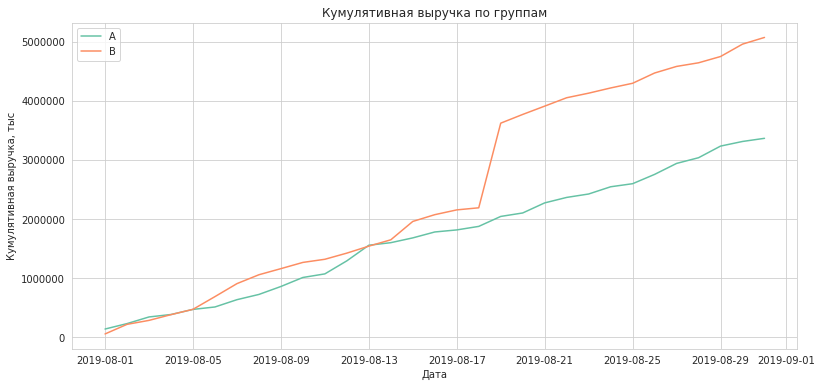

In [29]:
_ = plt.figure(figsize=(13,6))
_ = plt.plot(orders_a['date'], orders_a['revenue'], label='A')
_ = plt.plot(orders_b['date'], orders_b['revenue'], label='B')
_ = plt.legend()
_ = plt.title('Кумулятивная выручка по группам')
_ = plt.xlabel('Дата')
_ = plt.ylabel('Кумулятивная выручка, тыс')

По графику видно, что группа В показала стабильно более высокую выручку, особенно начиная с 18.08. Возможно, там случились выбросы или какие-то изменения на сайте, на которые группа В отреагировала лучше.

#### График кумулятивного среднего чека по группам

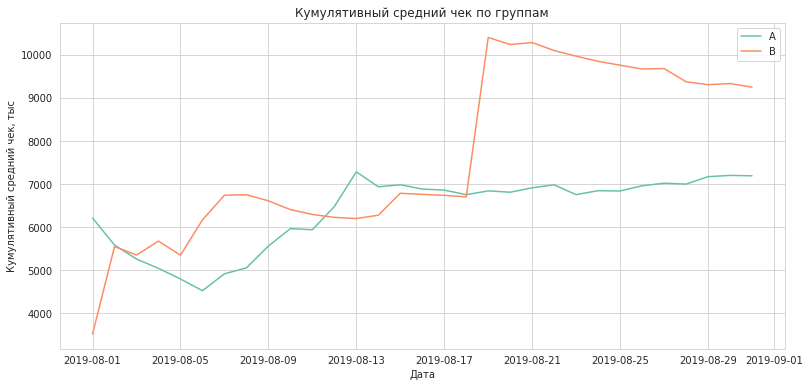

In [30]:
_ = plt.figure(figsize=(13,6))
_ = plt.plot(orders_a['date'], orders_a['revenue']/orders_a['num_of_orders'], label='A')
_ = plt.plot(orders_b['date'], orders_b['revenue']/orders_b['num_of_orders'], label='B')
_ = plt.legend()
_ = plt.title('Кумулятивный средний чек по группам')
_ = plt.xlabel('Дата')
_ = plt.ylabel('Кумулятивный средний чек, тыс')

График кумулятивного среднего чека подтверждает предположение, что где-то 18-19.08 случились большие продажи у группы В. 

#### График относительного изменения кумулятивного среднего чека группы B к группе A

Соединим горизонтально таблицы по группам, чтобы вычислить соотношение среднего чека.

In [31]:
merged_orders = orders_a.merge(orders_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])
merged_orders.head()

,date,num_of_orders_a,revenue_a,num_of_visitors_a,num_of_orders_b,revenue_b,num_of_visitors_b
0,2019-08-01,23,142779,718,17,59758,710
1,2019-08-02,42,234381,1336,40,221801,1290
2,2019-08-03,66,346854,1843,54,288850,1797
3,2019-08-04,77,388030,2556,68,385740,2564
4,2019-08-05,99,474413,3309,89,475648,3269


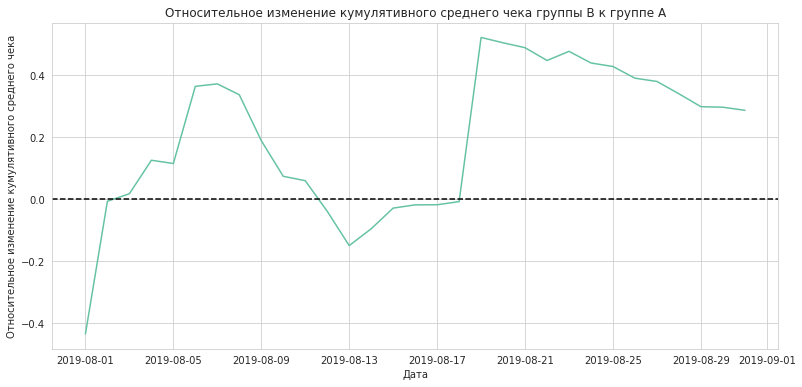

In [32]:
_ = plt.figure(figsize=(13,6))
_ = plt.plot(merged_orders['date'], 
  (merged_orders['revenue_b']/merged_orders['num_of_orders_b'])/(merged_orders['revenue_a']/merged_orders['num_of_orders_a'])-1)

_ = plt.axhline(y=0, color='black', linestyle='--')
_ = plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
_ = plt.xlabel('Дата')
_ = plt.ylabel('Относительное изменение кумулятивного среднего чека')

График показывает, что преимущественно средний чек группы В выше, чем у группы А, за исключением начала теста и конца второй недели. Также виден скачок 18.08, возможно, он был связан с выбросами. 

#### График кумулятивной конверсии по группам

Добавим столбец с конверсией в таблицы по группам.

In [33]:
orders_a['conversion'] = orders_a.num_of_orders / orders_a.num_of_visitors
orders_a.head()
orders_b['conversion'] = orders_b.num_of_orders / orders_b.num_of_visitors
orders_b.head()

,date,num_of_orders,revenue,num_of_visitors,conversion
0,2019-08-01,23,142779,718,0.032033
2,2019-08-02,42,234381,1336,0.031437
4,2019-08-03,66,346854,1843,0.035811
6,2019-08-04,77,388030,2556,0.030125
8,2019-08-05,99,474413,3309,0.029918


,date,num_of_orders,revenue,num_of_visitors,conversion
1,2019-08-01,17,59758,710,0.023944
3,2019-08-02,40,221801,1290,0.031008
5,2019-08-03,54,288850,1797,0.030050
7,2019-08-04,68,385740,2564,0.026521
9,2019-08-05,89,475648,3269,0.027225


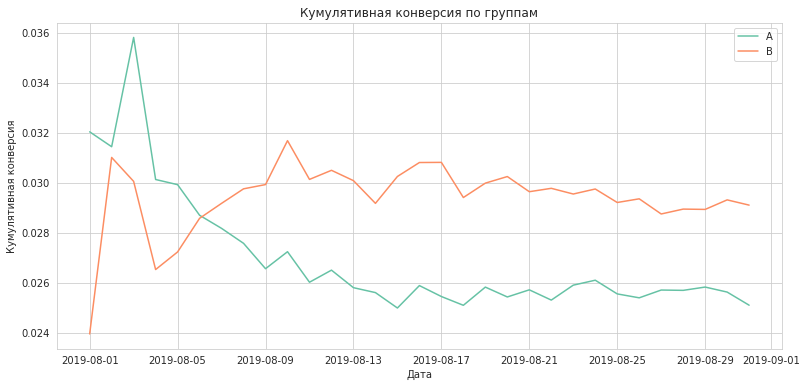

In [34]:
_ = plt.figure(figsize=(13,6))
_ = plt.plot(orders_a['date'], orders_a['conversion'], label='A')
_ = plt.plot(orders_b['date'], orders_b['conversion'], label='B')
_ = plt.legend()
_ = plt.title('Кумулятивная конверсия по группам')
_ = plt.xlabel('Дата')
_ = plt.ylabel('Кумулятивная конверсия')

По конверсии группа В также лучше, чем группа А, хотя важно отметить, что различия в конверсии более-менее установились только спустя 10 дней от начала тестирования. На первой же неделе группа А показывала лучшую конверсию.

#### График относительного изменения кумулятивной конверсии группы B к группе A

Объединим конверсии обеих групп в одну таблицу.

In [35]:
merged_conversions = orders_a[['date','conversion']].merge(orders_b[['date','conversion']], 
                                                           left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])
merged_conversions

,date,conversion_a,conversion_b
0,2019-08-01,0.032033,0.023944
1,2019-08-02,0.031437,0.031008
2,2019-08-03,0.035811,0.030050
3,2019-08-04,0.030125,0.026521
4,2019-08-05,0.029918,0.027225
5,2019-08-06,0.028694,0.028571
6,2019-08-07,0.028169,0.029170
7,2019-08-08,0.027570,0.029752
8,2019-08-09,0.026555,0.029922
9,2019-08-10,0.027235,0.031680


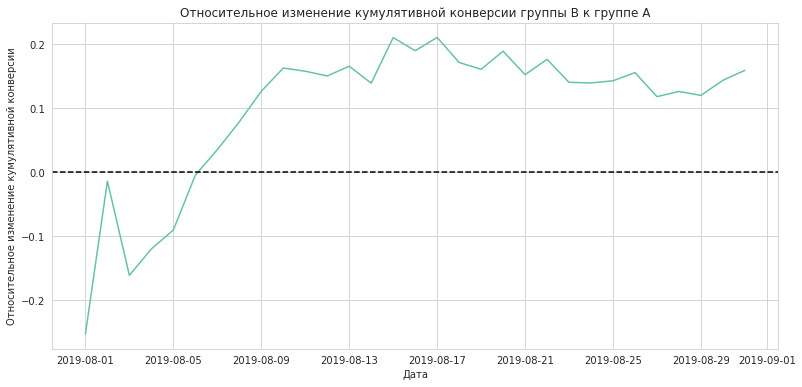

In [36]:
_ = plt.figure(figsize=(13,6))
_ = plt.plot(merged_conversions['date'], merged_conversions['conversion_b']/merged_conversions['conversion_a']-1)
_ = plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
_ = plt.axhline(y=0, color='black', linestyle='--')
_ = plt.xlabel('Дата')
_ = plt.ylabel('Относительное изменение кумулятивной конверсии')

В начале теста группа B несколько проигрывала группе A, затем в начале второй недели тестирования вышла вперёд и так там и держится. Вероятно, там внесли какие-то благоприятные изменения для группы В или случились выбросы.

#### Точечный график количества заказов по пользователям

,transaction_id
visitor_id,
3967698036,3
249864742,3
2108163459,3
2988190573,3
3908431265,3
611059232,3
2742574263,3
678354126,2
1404560065,2


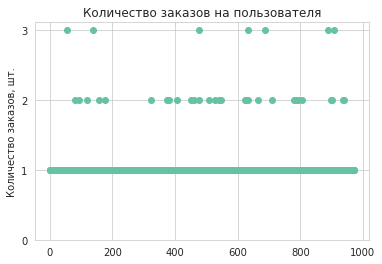

In [37]:
orders_by_visitors = orders.groupby('visitor_id').agg({'transaction_id':'nunique'})
orders_by_visitors.sort_values(by='transaction_id',ascending=False).head(10)
x_values_per_visitor = pd.Series(range(0,len(orders_by_visitors)))
_ = plt.scatter(x_values_per_visitor, orders_by_visitors['transaction_id'])
_ = plt.title('Количество заказов на пользователя')
_ = plt.yticks(np.arange(0, orders_by_visitors.transaction_id.max()+1))
_ = plt.ylabel('Количество заказов, шт.')

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей.

In [38]:
np.percentile(orders_by_visitors, [90, 95, 99])

array([1., 1., 2.])

График и персентили показывают, в основном покупают 1-2 раза, и только 7 посетителей совершили 3 покупки. Выберем границу в 99% для отсечения аномалий (не более 2х покупок на пользователя).

Выделим индексы пользователей, который совершили более 3х покупок, и создадим новую таблицу orders_filtered, из которой уберем этих пользователей.

In [39]:
visitors_to_drop = orders_by_visitors[orders_by_visitors.transaction_id > 2].index
visitors_to_drop

orders_filtered = orders.query('visitor_id not in @visitors_to_drop').copy()
orders_filtered

Int64Index([ 249864742,  611059232, 2108163459, 2742574263, 2988190573,
            3908431265, 3967698036],
           dtype='int64', name='visitor_id')

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A


## Поиск аномалий <a id="step3.2"></a> 

Построим точечный график стоимостей заказов.

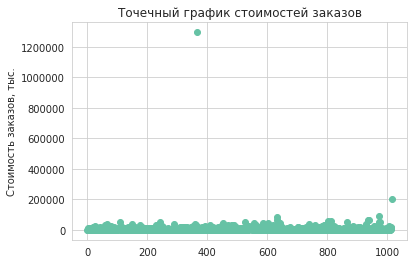

In [40]:
x_values = pd.Series(range(0,len(orders['revenue'])))
_ = plt.scatter(x_values, orders['revenue'])
_ = plt.title('Точечный график стоимостей заказов')
_ = plt.ylabel('Стоимость заказов, тыс.')

График показывает два явных выброса - около 200000 и 1200000, остальные заказы укладываются до 100000. Можно посмотреть на этот промежутов подробнее.

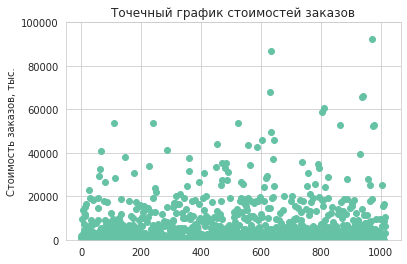

In [41]:
x_values = pd.Series(range(0,len(orders['revenue'])))
_ = plt.scatter(x_values, orders['revenue'])
_ = plt.ylim(0, 100000)
_ = plt.title('Точечный график стоимостей заказов')
_ = plt.ylabel('Стоимость заказов, тыс.')

Посчитаем 95-й и 99-й перцентили стоимости заказов и выберем границу для определения аномальных заказов.

In [42]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

График и персентили хорошо показывают, что основная часть заказов находится в пределах 60000 тыс. Поэтому можно выбрать границу в 99% для отсечения аномальных заказов (не больше 53904). 

Выделим индексы строк, где стоимость заказов превышает 99 персентиль, и обновим таблицу orders_filtered, из которой уберем эти строки.

In [43]:
percentile_99 = orders['revenue'].quantile(.99)
percentile_99
revenue_to_drop = orders.query('revenue > @percentile_99').index
revenue_to_drop

orders_filtered = orders_filtered.drop(revenue_to_drop)
orders_filtered

53904.0

Int64Index([425, 743, 744, 940, 949, 1099, 1103, 1136, 1196], dtype='int64')

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1190,38478481,1197745035,2019-08-14,8600,B
1191,3592955527,608641596,2019-08-14,16490,B
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A


## Подсчет статистической значимости <a id="step3.3"></a> 

Напишем функцию, которая будет считать статистическую значимость по критерию Манна-Уитни. Потом применим ее на "сырых" и "очищенных" данных.

In [44]:
def count_mannwhitneyu(sample_a, sample_b, h0, h1):
    alpha = .05
    results = stats.mannwhitneyu(sample_a, sample_b)
    print('p-значение:', results.pvalue.round(5))
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу. Иначе говоря,", h1)
    else:
        print("Не получилось отвергнуть нулевую гипотезу. Иначе говоря,", h0)

### Различия в конверсии между группами по «сырым» данным

Сделаем срезы по количеству покупок на одного покупателя по группам. Затем подготовим выборки conversion_sample_a и conversion_sample_b к проверке критерием Манна-Уитни: добавим к полученным данным количество нулей, которое соответствует разнице между суммой посетителей и количеством записей о заказах.

In [45]:
orders_by_users_a = orders.query('group == "A"').groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users_a.columns = ['user_id', 'orders']
orders_by_users_a.head()

orders_by_users_b = orders.query('group == "B"').groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users_b.columns = ['user_id', 'orders']
orders_by_users_b.head()

,user_id,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


,user_id,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


In [46]:
conversion_sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index=np.arange(
         merged_orders['num_of_visitors_a'].max() - len(orders_by_users_a['orders'])), name='orders')], axis=0)
conversion_sample_a.sample(5)

conversion_sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(0, index=np.arange(
         merged_orders['num_of_visitors_b'].max() - len(orders_by_users_b['orders'])), name='orders')], axis=0)
conversion_sample_b.sample(5)

7900     0
7088     0
11968    0
17840    0
6676     0
Name: orders, dtype: int64

15219    0
3050     0
13094    0
2549     0
112      0
Name: orders, dtype: int64

Пропишем гипотезы:
- H0 - статистически значимых различий в конверсии между группами нет
- H1 - статистически значимые различия в конверсии между группами есть

Применим функцию.

In [47]:
conversion_h0 = 'статистически значимых различий в конверсии между группами нет.'
conversion_h1 = 'статистически значимые различия в конверсии между группами есть.'

count_mannwhitneyu(conversion_sample_a, conversion_sample_b, conversion_h0, conversion_h1)

p-значение: 0.00554
Отвергаем нулевую гипотезу. Иначе говоря, статистически значимые различия в конверсии между группами есть.


Посчитаем относительный прирост конверсии группы В.

In [48]:
print('Относительный прирост конверсии группы B:', (conversion_sample_b.mean()/conversion_sample_a.mean()-1).round(3))

Относительный прирост конверсии группы B: 0.16


Таким образом на "сырых" данных есть статистически значимая разница по конверсии. Конверсия группы В на 16% выше конверсии группы А.

### Различия в среднем чеке заказа между группами по «сырым» данным

Подготовим выборки avg_receipt_sample_a и avg_receipt_sample_b к проверке критерием Манна-Уитни: сделаем срез по доходу с группы.

In [49]:
avg_receipt_sample_a = orders.query('group == "A"').revenue
avg_receipt_sample_a.head()
avg_receipt_sample_b = orders.query('group == "B"').revenue
avg_receipt_sample_b.head()

7      1044
8     13710
10     4008
12     7370
14    10980
Name: revenue, dtype: int64

0    1650
1     730
3    9759
4    2308
5    2210
Name: revenue, dtype: int64

Пропишем гипотезы:
- H0 - статистически значимых различий в среднем чеке заказа между группами нет
- H1 - статистически значимые различия в среднем чеке заказа между группами есть

Возьмем альфа стандартно равный 0.05 и применим критерий Манна Уитни.

In [50]:
avg_receipt_h0 = 'статистически значимых различий в среднем чеке заказа между группами нет.'
avg_receipt_h1 = 'статистически значимые различия в среднем чеке заказа между группами есть.'

count_mannwhitneyu(avg_receipt_sample_a, avg_receipt_sample_b, avg_receipt_h0, avg_receipt_h1)

p-значение: 0.41475
Не получилось отвергнуть нулевую гипотезу. Иначе говоря, статистически значимых различий в среднем чеке заказа между группами нет.


In [51]:
print('Относительное изменение среднего чека группы B к группе A:', 
      (avg_receipt_sample_b.mean()/avg_receipt_sample_a.mean()-1).round(3))

Относительное изменение среднего чека группы B к группе A: 0.287


Не получилось отвергнуть нулевую гипотезу несмотря на то, что относительное различие между средние чеками составляет 28.7%. Надо посмотреть, не повлияли ли здесь выбросы. 

### Различия в конверсии между группами по «очищенным» данным

Подготовим новые выборки по тому же принципу на отфильтрованных от выбросов данных.

In [52]:
orders_by_users_a_filtered = orders_filtered.query('group == "A"').groupby('visitor_id', as_index=False)\
                                                                  .agg({'transaction_id':'nunique'})
orders_by_users_a_filtered.columns = ['user_id', 'orders']
orders_by_users_a_filtered.head()

orders_by_users_b_filtered = orders_filtered.query('group == "B"').groupby('visitor_id', as_index=False)\
                                                                  .agg({'transaction_id':'nunique'})
orders_by_users_b_filtered.columns = ['user_id', 'orders']
orders_by_users_b_filtered.head()

,user_id,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


,user_id,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


In [53]:
conversion_sample_a_filtered = pd.concat([orders_by_users_a_filtered['orders'], pd.Series(0, index=np.arange(
         merged_orders['num_of_visitors_a'].max() - len(orders_by_users_a_filtered['orders'])), name='orders')], axis=0)
conversion_sample_a_filtered.sample(5)

conversion_sample_b_filtered = pd.concat([orders_by_users_b_filtered['orders'], pd.Series(0, index=np.arange(
         merged_orders['num_of_visitors_b'].max() - len(orders_by_users_b_filtered['orders'])), name='orders')], axis=0)
conversion_sample_b_filtered.sample(5)

767     0
4950    0
7444    0
616     0
3893    0
Name: orders, dtype: int64

11884    0
3207     0
783      0
618      0
1514     0
Name: orders, dtype: int64

Применим фукнцию для подсчета статистической значимости.

In [54]:
count_mannwhitneyu(conversion_sample_a_filtered, conversion_sample_b_filtered, conversion_h0, conversion_h1)

p-значение: 0.0035
Отвергаем нулевую гипотезу. Иначе говоря, статистически значимые различия в конверсии между группами есть.


In [55]:
print('Относительный прирост конверсии группы B:', 
      (conversion_sample_b_filtered.mean()/conversion_sample_a_filtered.mean()-1).round(3))

Относительный прирост конверсии группы B: 0.189


Статистическая значимость есть и на отфильтрованных данных, а конверсия группы В выше теперь почти на 19%. 

### Различия в среднем чеке заказа между группами по «очищенным» данным

Создадим новые выборки по тому же принципу на отфильтрованной таблице.

In [56]:
avg_receipt_sample_a_filtered = orders_filtered.query('group == "A"').revenue
avg_receipt_sample_a_filtered.head()
avg_receipt_sample_b_filtered = orders_filtered.query('group == "B"').revenue
avg_receipt_sample_b_filtered.head()

7      1044
8     13710
10     4008
12     7370
14    10980
Name: revenue, dtype: int64

0    1650
1     730
3    9759
4    2308
5    2210
Name: revenue, dtype: int64

Применим функцию.

In [57]:
count_mannwhitneyu(avg_receipt_sample_a_filtered, avg_receipt_sample_b_filtered, avg_receipt_h0, avg_receipt_h1)

p-значение: 0.39385
Не получилось отвергнуть нулевую гипотезу. Иначе говоря, статистически значимых различий в среднем чеке заказа между группами нет.


In [58]:
print('Относительное изменение среднего чека группы B к группе A:', 
      (avg_receipt_sample_b_filtered.mean()/avg_receipt_sample_a_filtered.mean()-1).round(3))

Относительное изменение среднего чека группы B к группе A: -0.032


На отфильтрованных данных все равно не получилось отвергнуть нулевую гипотезу, и мы видим, что теперь средний чек на 3% выше в группе А. 

## Выводы <a id="step3.4"></a> 

Анализ на предмет аномалий выявил, что 99% пользователей делают не более 2 заказов на сумму не более 53 904 р. Данные по этим пользователям и заказам были удалены для проверки статистической значимости. 

Хотя графики кумулятивных метрик показывали, что по конверсии, доходу и среднему чеку лидирует группа В, проверка критерием Манна-Уитни показала, что **статистичеки значимым является только разница в конверсии, которая в группе В на 19% выше**.

# Шаг 4. Общие выводы <a id="step4"></a> 

### Приоритизирование гипотез
Были рассмотрены гипотезы по увеличению выручки интернет-магазина в рамках фреймворков ICE и RICE. Основным их различием является параметр Reach, или охват, который показывает, скольких пользователей затронет изменение, которое хотят внести. Для увеличения выручки магазина параметр охвата важен, поэтому следует ориентироваться на результаты проверки гипотез по фреймфорку RICE, где на первых трех местах расположились следующие гипотезы:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	(112.0)
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа (56.0)
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	(40.0)
3. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	(40.0)


### Анализ А/В-теста
Было обнаружено, что 15% заказов пришлось на пользователей, которые попали в обе группы, следовательно, было решено удалить этих пользователей, чтобы это не повлияло на результаты анализа теста. 

Анализ на предмет аномалий выявил, что 99% пользователей делают не более 2 заказов на сумму не более 53 904 р. Данные по этим пользователям и заказам также были удалены для проверки статистической значимости. 

Хотя графики кумулятивных метрик показывали, что по конверсии, доходу и среднему чеку ко второй половине теста уверенно лидирует группа В, проверка критерием Манна-Уитни показала, что статистичеки значимым является только разница в конверсии, которая в группе В на 19% выше.

По результатам теста можно принять решение его остановить, зафиксировав победу группы В по увеличению конверсии. 